In [173]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')
sns.set(rc={'figure.figsize':(20,8.27)})
%matplotlib inline

## Define sample 
For this we need to find the list of New York city zip codes

In [69]:
# Source https://worldpostalcode.com/united-states/new-york/new-york-city 
# retrieved on 05/28/2020
df_zipcodes = pd.read_csv('nyc_boroughs.csv', index_col = 0)
df_zipcodes.head()

,zip,borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


This looks like a good sample of zip codes that can be used for the analysis

In [70]:
df_zipcodes.groupby('borough').count()

,zip
borough,
Bronx,50
Brooklyn,86
Manhattan,192
Queens,126
Staten,26


In [82]:
df_zipcodes.shape

(480, 2)

#### Feature 1 - condo prices
Use the list of sample zip codes to get good price estimates, in my case, latest estimates of 2-bedroom condo units

In [71]:
# Source: https://www.zillow.com/research/data/
# retrieved on 05-18-2020
df_prices = pd.read_csv('condo_prices.csv', index_col=0)

In [72]:
# This data set contains zillow estimates for the entire nation
df_prices.shape

(10939, 299)

In [77]:
# Inspect the columns 
df_prices.head()

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,215591.0,214255.0,...,1249908.0,1239499.0,1219219.0,1203053.0,1188642.0,1182534.0,1175894.0,1153407.0,1123011.0,1085220.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,194597.0,194456.0,...,403689.0,403756.0,403181.0,402122.0,401073.0,400025.0,399451.0,399424.0,400541.0,402007.0
61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,270200.0,270272.0,...,1196262.0,1193635.0,1185743.0,1169593.0,1159431.0,1162100.0,1182107.0,1202722.0,1216983.0,1218097.0
91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,NaN,NaN,...,201988.0,202900.0,203401.0,203926.0,204387.0,204812.0,204325.0,203251.0,202182.0,201069.0
84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,195233.0,195317.0,...,449199.0,449311.0,448826.0,447771.0,446923.0,445917.0,445015.0,444873.0,445419.0,446479.0


In [81]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_prices.drop(df_prices.columns.difference(['RegionName','Metro', '2019-11-30']), 1, inplace=True)


In [83]:
df_nyc_prices = df_zipcodes.merge(df_prices, left_on='zip', right_on='RegionName')
df_nyc_prices.shape

(314, 5)

Merged data set has less rows than original zip codes list but thats fine as there might have been some P.O boxes or reserved codes. The new list now has meaningful first feature - price estimate.

Check if all observations map to New York city boroughs or if there any unexpected values. Looks fine so far!

In [87]:
df_nyc_prices.groupby('borough').count()

,zip,RegionName,Metro,2019-11-30
borough,,,,
Bronx,32,32,32,32
Brooklyn,76,76,76,76
Manhattan,82,82,82,82
Queens,102,102,102,102
Staten,22,22,22,22


In [92]:
df_nyc_prices['2019-11-30'].isnull().values.any()

False

In [93]:
df_nyc_prices['2019-11-30'].isna().values.any()

False

Finally, rename the column to 'Price'

In [95]:
df_nyc_prices.rename(columns={'2019-11-30':'Price'}, inplace=True)

In [96]:
df_nyc_prices.head()

,zip,borough,RegionName,Metro,Price
0,10001,Manhattan,10001,New York-Newark-Jersey City,1274766.0
1,10001,Manhattan,10001,New York-Newark-Jersey City,1274766.0
2,10002,Manhattan,10002,New York-Newark-Jersey City,1103197.0
3,10002,Manhattan,10002,New York-Newark-Jersey City,1103197.0
4,10003,Manhattan,10003,New York-Newark-Jersey City,1065001.0


#### Feature 2 - rental estimates

In [115]:
df_rents=pd.read_csv('condo_rentals.csv', index_col = 0)

In [116]:
df_rents.shape

(13181, 119)

In [117]:
df_rents.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0
61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,3269.0,3304.0,3320.0,3322.0,...,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,NaN,4123.0,4079.0,NaN
91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1547.0,1549.0,1560.0,1560.0,...,1765.0,1755.0,1751.0,1752.0,1754.0,1759.0,1764.0,1769.0,1776.0,1778.0
84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,1922.0,1925.0,1921.0,1908.0,...,2245.0,2289.0,2332.0,2372.0,2398.0,2412.0,2348.0,2356.0,2311.0,NaN


In [118]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_rents.drop(df_rents.columns.difference(['RegionName','Metro', '2019-11']), 1, inplace=True)

In [119]:
df_rents.head()

,RegionName,Metro,2019-11
RegionID,,,
61639,10025,New York-Newark-Jersey City,3873.0
84654,60657,Chicago-Naperville-Elgin,NaN
61637,10023,New York-Newark-Jersey City,4123.0
91982,77494,Houston-The Woodlands-Sugar Land,1769.0
84616,60614,Chicago-Naperville-Elgin,2356.0


In [120]:
df_nyc_prices_rents = df_nyc_prices.merge(df_rents, left_on='zip', right_on='RegionName')
df_nyc_prices_rents.shape

(272, 8)

More observations (rows) were lost because not all zip codes had a rental estimate

In [121]:
df_nyc_prices_rents.groupby('borough').count()

,zip,RegionName_x,Metro_x,Price,RegionName_y,Metro_y,2019-11
borough,,,,,,,
Bronx,32,32,32,32,32,32,30
Brooklyn,68,68,68,68,68,68,58
Manhattan,52,52,52,52,52,52,50
Queens,98,98,98,98,98,98,98
Staten,22,22,22,22,22,22,22


Moreover, from the grouped table above, it seems that some zip codes do have a price estimate but do not have rent estimate. So, drop missing values and check the data set.

In [132]:
df_nyc_prices_rents.dropna(inplace=True)

In [133]:
df_nyc_prices_rents['2019-11'].isnull().values.any()

False

In [134]:
df_nyc_prices_rents['2019-11'].isna().values.any()

False

Rename column 'Rent'

In [135]:
df_nyc_prices_rents.rename(columns={'2019-11':'Rent'}, inplace=True)

#### EDA of Sample 

Inspect the rents visually with box plots

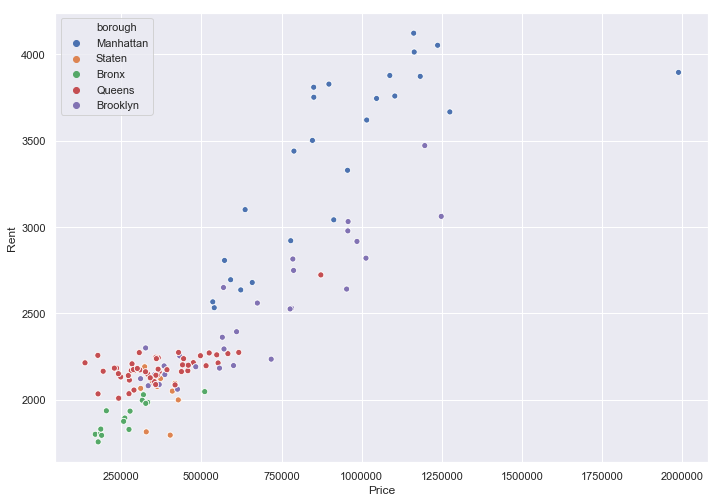

In [164]:
sns.scatterplot(x='Price', y='Rent', data=df_nyc_prices_rents, hue = 'borough')
plt.gcf().set_size_inches(11.7, 8.27)
plt.show()

When plotting 'Rent' against 'Price" it seems that the data is not homegeneous at all. 

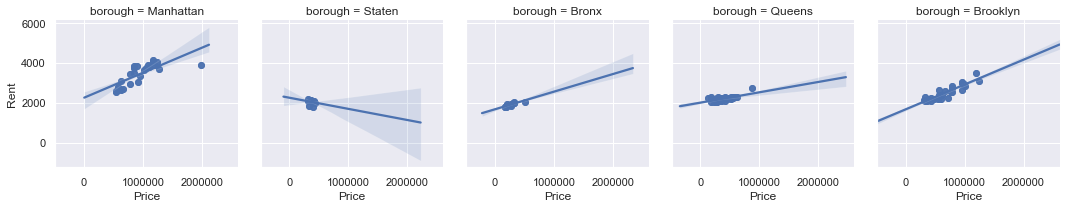

In [172]:
g1 = sns.lmplot(x='Price', y='Rent', data=df_nyc_prices_rents, ci=85,
                col='borough', height=3, robust=False)
g1 = g1.set_axis_labels('Price', 'Rent')
plt.show()

Splitting by boroughs confirms this idea. When looking at the slope of regression lines, rent/price relationship appears to be different. There are at list 3 distinct groups: 1) Manhattan, 2) Staten,  and 3) Bronx, Queens and Brooklyn.

#### *k*-means clustering 

In [175]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
X = df_nyc_prices_rents[['Price', 'Rent']]
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [176]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 323790.14473684,    2094.46052632],
       [1116880.75      ,    3487.45      ],
       [ 651183.87878788,    2619.57575758]])

In [178]:
labels = k_means.labels_
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 2, 2, 0, 0,
       1, 1, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0], dtype=int32)

In [179]:
df_nyc_prices_rents["Cluster"] = labels
df_nyc_prices_rents.head(5)

,zip,borough,RegionName_x,Metro_x,Price,RegionName_y,Metro_y,Rent,Cluster
0,10001,Manhattan,10001,New York-Newark-Jersey City,1274766.0,10001,New York-Newark-Jersey City,3667.0,1
1,10001,Manhattan,10001,New York-Newark-Jersey City,1274766.0,10001,New York-Newark-Jersey City,3667.0,1
2,10002,Manhattan,10002,New York-Newark-Jersey City,1103197.0,10002,New York-Newark-Jersey City,3759.0,1
3,10002,Manhattan,10002,New York-Newark-Jersey City,1103197.0,10002,New York-Newark-Jersey City,3759.0,1
4,10004,Manhattan,10004,New York-Newark-Jersey City,1236730.0,10004,New York-Newark-Jersey City,4053.0,1


In [180]:
df_nyc_prices_rents.groupby('Cluster').count()

,zip,borough,RegionName_x,Metro_x,Price,RegionName_y,Metro_y,Rent
Cluster,,,,,,,,
0,152,152,152,152,152,152,152,152
1,40,40,40,40,40,40,40,40
2,66,66,66,66,66,66,66,66


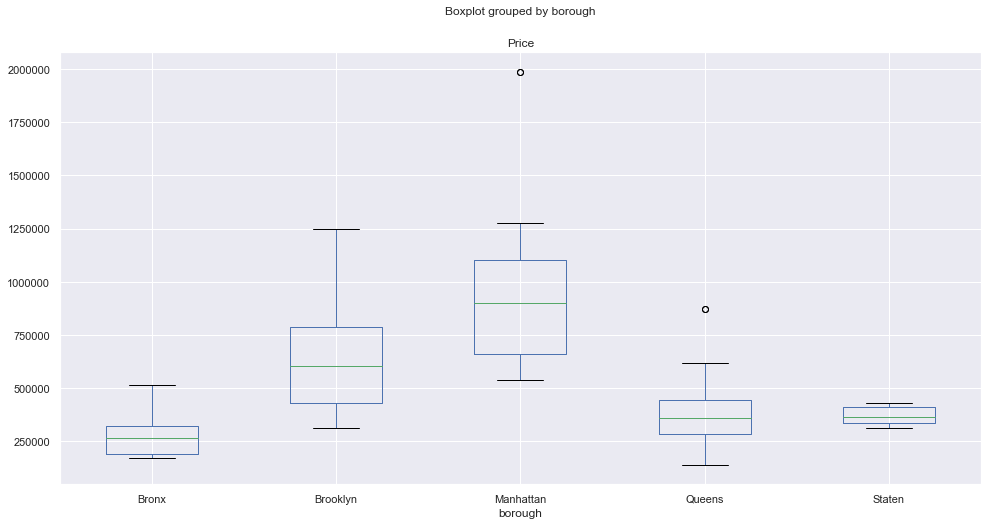

In [186]:
#df_nyc_prices_rents.groupby('Cluster').boxplot()
ax = df_nyc_prices_rents.boxplot(column='Price', by='borough', figsize=(16, 8), rot=0)
#ax = sample_listings_df.boxplot(column='Profitability', by='Zipcode', figsize=(16, 8), rot=90)

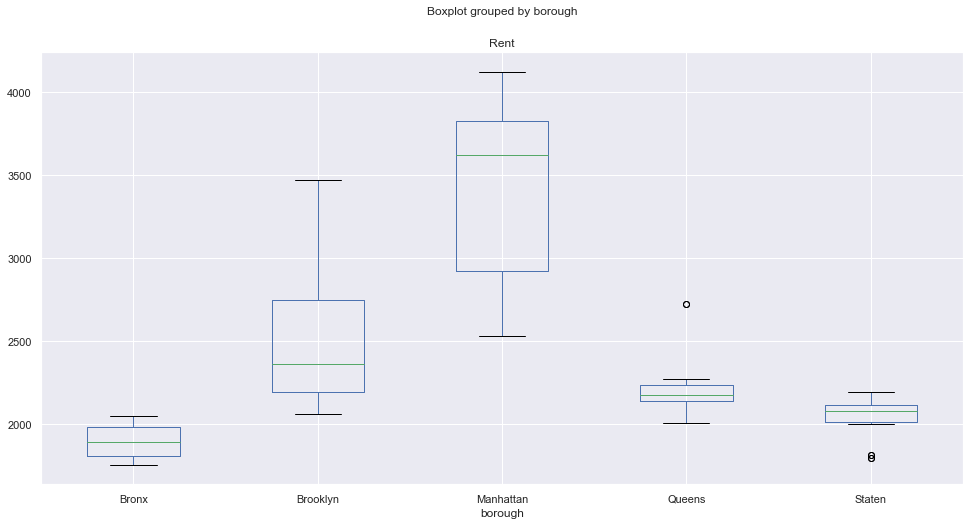

In [188]:
ax = df_nyc_prices_rents.boxplot(column='Rent', by='borough', figsize=(16, 8), rot=0)

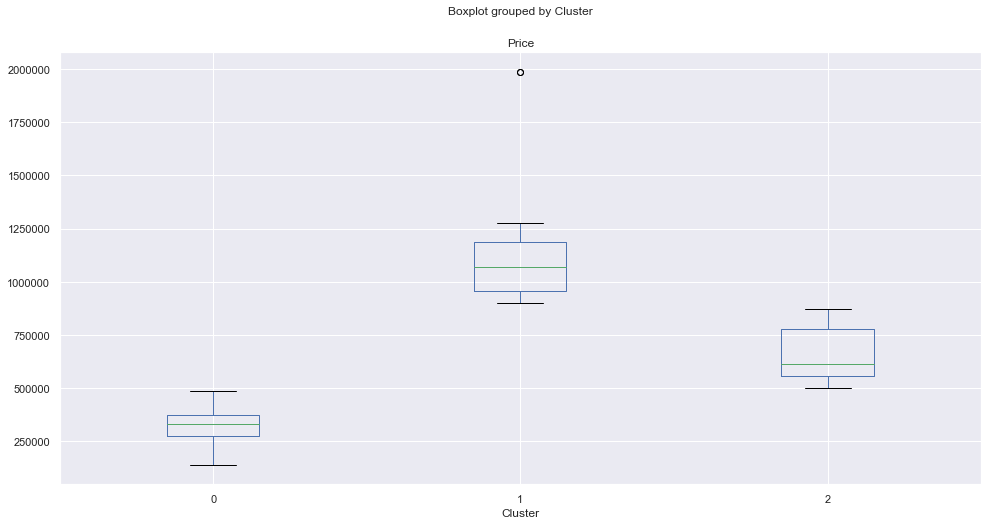

In [190]:
ax = df_nyc_prices_rents.boxplot(column='Price', by='Cluster', figsize=(16, 8), rot=0)

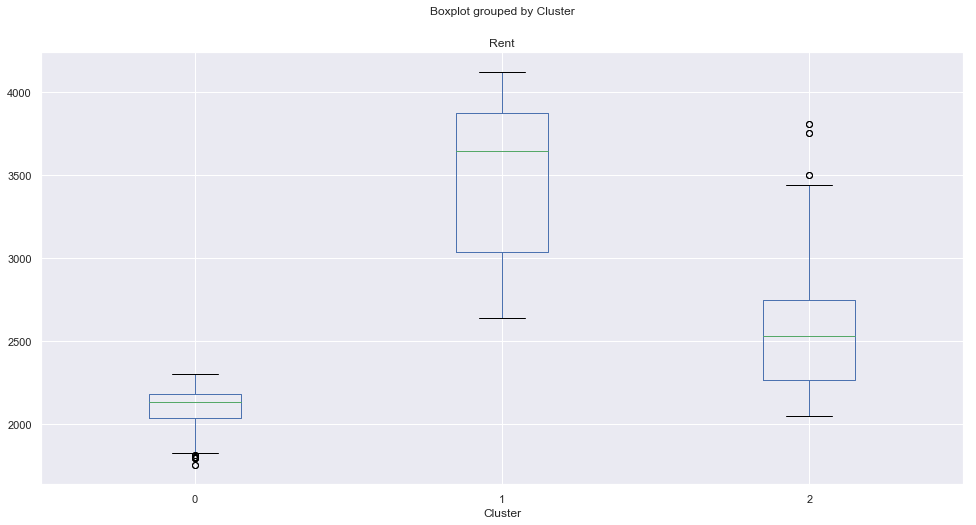

In [191]:
ax = df_nyc_prices_rents.boxplot(column='Rent', by='Cluster', figsize=(16, 8), rot=0)

In [ ]:
# TODO:
# 1) load condo prices - sort for NYC only, store data file, box plot by zip
# 2) load condo rents  - sort and store NYC, box plot by zip
# 3) merge data sets on zip codes, scatter plot x = condo_princes y = condo_rents
# 4) run 3 or 4 centers clustering algorithms as shown in k-means
# 5) group zip codes by clusters and map them using folio
# 6) loand venues data
# 7) count most popular by clusters
# 8) run trees
# 9) plot top of the tree
# 10) check with lasso regression